In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils
#from SpykeTorch import makeInput
#import cifar10

import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time

In [2]:
rf_size = 28 # Receptive field size that will be provided as input to the column
num_neurons = rf_size*rf_size # Number of excitatory neurons in the column
startposition = 0 # Start position of the receptive field w.r.t. top left corner of image
threshold = 75 # Firing threshold for every excitatory neuron
timesteps = 8 # Resolution for timesteps and weights


#if torch.cuda.is_available():
#    torch.set_default_tensor_type('torch.cuda.FloatTensor')
#    dtype = torch.cuda.FloatTensor

In [3]:
class PreProcTransform:
    def __init__(self, filter, timesteps = timesteps):
        self.to_tensor = transforms.ToTensor() # Convert to tensor
        self.filter = filter # Apply OnOff filtering
        self.temporal_transform = utils.Intensity2Latency(timesteps) # Convert pixel values to time
                                                    # Higher value corresponds to earlier spiketime
        self.crop = utils.Crop(startposition, rf_size) # Crop the image to form the receptive field
        
    def __call__(self, image):
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0) # Adds a temporal dimension at the beginning
        image = self.filter(image)
        temporal_image = self.temporal_transform(image)
        temporal_image = temporal_image.sign() # This will create spikes
        return self.crop(temporal_image)
        
kernels = [utils.OnKernel(3), utils.OffKernel(3)]
inchannels = len(kernels)

filter = utils.Filter(kernels, padding = 2, thresholds = 50)
preproc = PreProcTransform(filter)

In [4]:
data_root = "data"
MNIST_train = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=True, download=True, transform = preproc))
MNIST_test = utils.CacheDataset(torchvision.datasets.MNIST(root=data_root, train=False, download=True, transform = preproc))
MNIST_trainLoader = DataLoader(MNIST_train, batch_size=1000, shuffle=True)
MNIST_testLoader = DataLoader(MNIST_test, batch_size=1000, shuffle=True)

In [5]:
class Column(nn.Module):
    def __init__(self):
        super(Column, self).__init__()
        # Local Convolution layer which creates columns with unique weights (NOT shared weights). The
        # number of columns is based on input_size, kernel_size and stride. Here since we are simulating
        # only one column, the input_size and kernel_size are kept same.
        self.ec = snn.HopfieldNetwork(10/128, 10/128, 24/128, 72/128, 4/128, timesteps)
        # STDP module which implements the given STDP rule for the above layer (a single column in this case)
        self.stdp = snn.ModSTDP(self.ec, 10/128, 10/128, 1/128, 96/128, 4/128, maxweight = timesteps)
        
    def forward(self, rec_field):
        ### Start of Excitatory Column ###
        out = self.ec(rec_field)
        #spike, pot = sf.fire(out, threshold, True)
        ### End of Excitatory Column ###
        ### Start of Lateral Inhibition ###
        #out = sf.pointwise_inhibition(pot).sign()
        ### End of Lateral Inhibition ###
        return out

In [6]:
#set up pure hebbian no STDP and STDP columns

MyColumn=Column()
train_pattern = []
for i in range(15,17):
    train_pattern.append(torch.sum(torch.sum(MNIST_train[i][0],dim=0),dim=0))

MyColumn.ec.train_weights(train_pattern)

noSTDPcolumn = Column()
noSTDPcolumn.ec.train_weights(train_pattern)


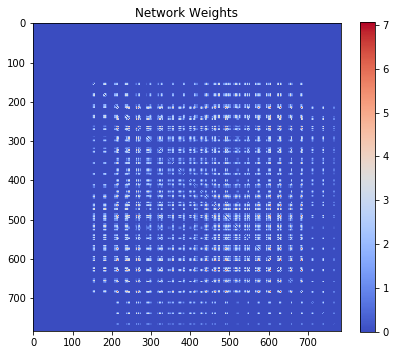

In [7]:
plt.figure(figsize=(6, 5))
w_mat = plt.imshow(MyColumn.ec.W, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.savefig("weights.png")
plt.show()

In [8]:
#train pure hebbian no STDP and STDP columns
outSTDP=[]
out = []
for i in range(15,17):
    testPattern = []
    testPattern.append(torch.sum(MNIST_train[i][0],dim=1).reshape(8,784).clone())
    out.append(noSTDPcolumn.ec.forward(testPattern,threshold=100,num_iter=20, noSTDP=True).clone())

for j in range(0,50):
    array = []
    print("at step", j)
    for i in range(15,17):
        testPattern = []
        testPattern.append(torch.sum(MNIST_train[i][0],dim=1).reshape(8,784).clone())
        array.append(MyColumn.ec.forward(testPattern,threshold=100,num_iter=20).clone())
    outSTDP.append(array)

took3 iterations
took3 iterations
at step0
took3 iterations
took3 iterations
at step1
took4 iterations
took3 iterations
at step2
took5 iterations
took4 iterations
at step3


KeyboardInterrupt: 

saving images
saving iteration1
saving iteration2
saving iteration3
saving iteration4
saving iteration5
saving iteration6
saving iteration7
saving iteration8
saving iteration9
saving iteration10
saving iteration11
saving iteration12
saving iteration13
saving iteration14
saving iteration15
saving iteration16
saving iteration17
saving iteration18
saving iteration19
saving iteration20
saving iteration21
saving iteration22
saving iteration23
saving iteration24
saving iteration25
saving iteration26
saving iteration27
saving iteration28
saving iteration29
saving iteration30
saving iteration31
saving iteration32
saving iteration33
saving iteration34
saving iteration35
saving iteration36
saving iteration37
saving iteration38
saving iteration39
saving iteration40
saving iteration41
saving iteration42
saving iteration43
saving iteration44
saving iteration45
saving iteration46
saving iteration47
saving iteration48
saving iteration49
saving iteration50


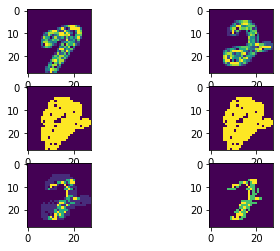

In [9]:
#save figures
print("saving images")
for it in range(1,51):
    print("saving iteration ", it)
    for i in range(0,2):
        plt.subplot(3,2,i+1), plt.imshow(train_pattern[i])
        plt.subplot(3,2,2+1+i), plt.imshow(torch.sum(out[i].squeeze(0),dim=0))
        plt.subplot(3,2,4+1+i), plt.imshow(torch.sum(outSTDP[it-1][i].squeeze(0),dim=0))
    plt.savefig("iterationThree"+ str(it)+".png")